In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from scipy.stats import probplot
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import os
import sys
import pygeohash as gh

%matplotlib inline

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows', None)

In [ ]:
url = 'https://github.com/C-Ameseder/1.1.HousePricing_Regression/blob/main/1.Data/regression_data_clean.csv?raw=true'
data = pd.read_csv(url)
data_copy = pd.read_csv(url)

### Exploratory data analysis


1.   eye ball the data
2.   check for nulls
3.   type and rename the columns
4.   check your Y  






In [ ]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,10/13/14,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,12/9/14,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2/25/15,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,12/9/14,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,2/18/15,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000


In [ ]:
for col in data.columns:
    pct_missing = np.mean(data[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

id - 0%
date - 0%
bedrooms - 0%
bathrooms - 0%
sqft_living - 0%
sqft_lot - 0%
floors - 0%
waterfront - 0%
view - 0%
condition - 0%
grade - 0%
sqft_above - 0%
sqft_basement - 0%
yr_built - 0%
yr_renovated - 0%
zipcode - 0%
lat - 0%
long - 0%
sqft_living15 - 0%
sqft_lot15 - 0%
price - 0%


In [ ]:
def display_missing(df):
    """shows the number of missing values of each column for a date_frame, if there is one"""
    for col in df.columns.tolist():
        if df[col].isnull().sum():
            print('{} column missing values: {}/{}'.format(col, df[col].isnull().sum(), len(df)))
    print ('Done checking for missing values')


display_missing(data)

Done checking for missing values


In [ ]:
data.dtypes

id                 int64
date              object
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
price              int64
dtype: object

###Target distribution

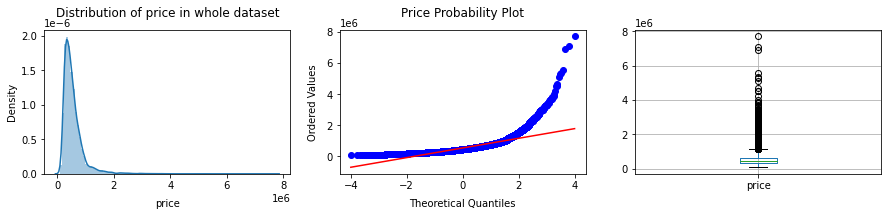

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,2))
plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None)

sns.distplot(data['price'], hist=True, bins = 100, ax=ax1)
probplot(data['price'], plot=ax2)
data.boxplot('price', ax=ax3)

ax1.set_xlabel('price', size=10, labelpad=8)
ax2.set_xlabel('Theoretical Quantiles', size=10, labelpad=8)
ax2.set_ylabel('Ordered Values', size=10, labelpad=8)

ax1.set_title('Distribution of price in whole dataset', size=12, y=1.05)
ax2.set_title('Price Probability Plot', size=12, y=1.05)

plt.show()

###Correlation matrix


1.   X's dont have to be highly correlated in linear regression (consider dropping or engineering if close to 1 
2.   X's dont have to be loosely correlated to the Y (consider dropping or engineering when close to 0 - i.e. between -0.25 and +0.25)



In [ ]:
num=data.select_dtypes(include='number')
cat=data.select_dtypes(include='category')

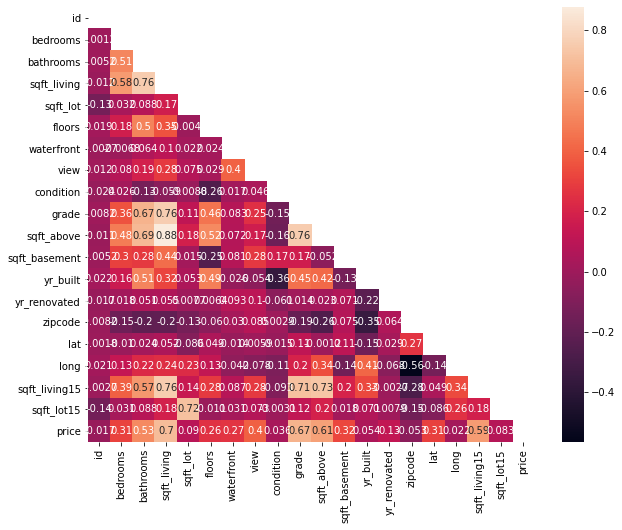

In [ ]:
correlations_matrix= num.corr()
mask = np.zeros_like(correlations_matrix)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)
plt.show()

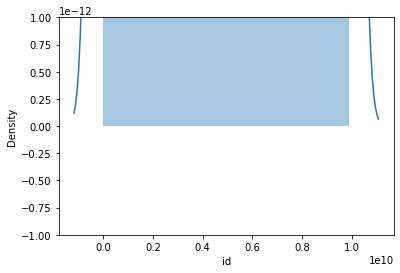

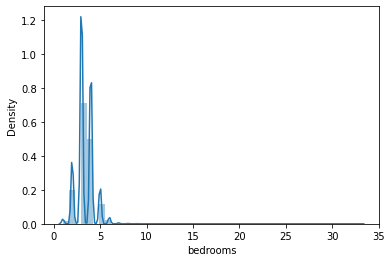

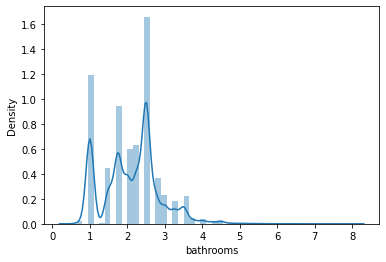

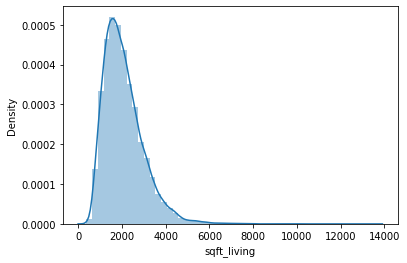

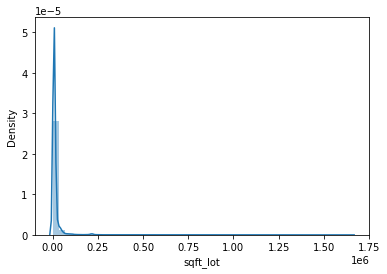

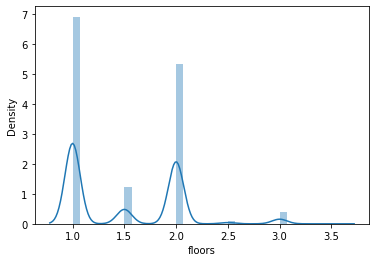

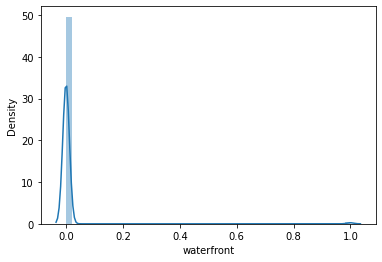

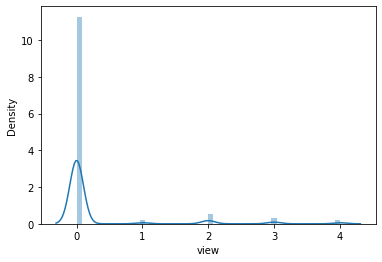

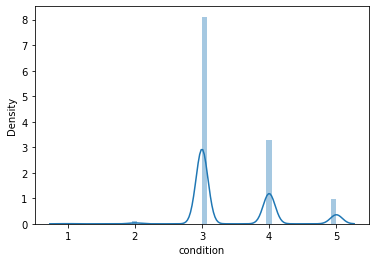

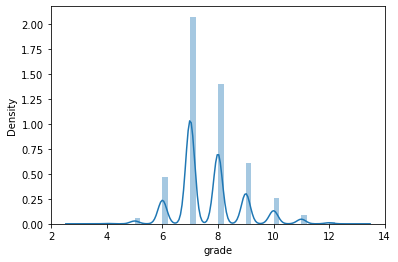

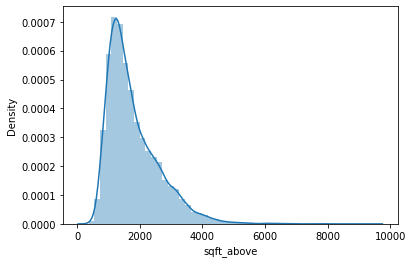

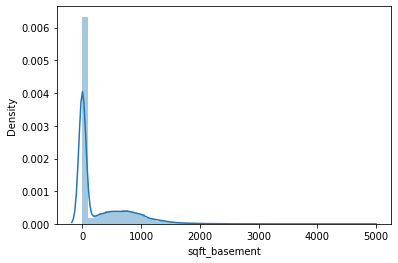

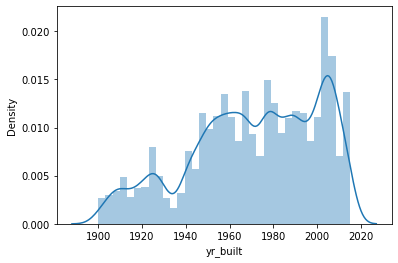

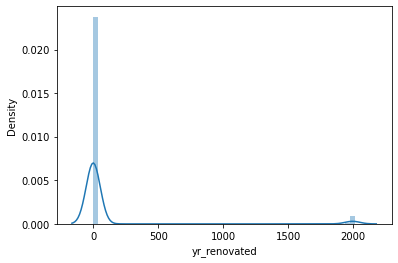

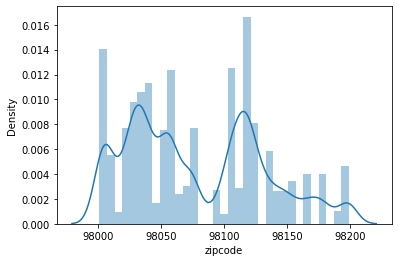

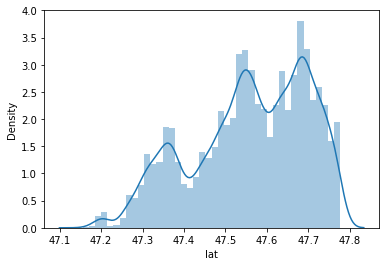

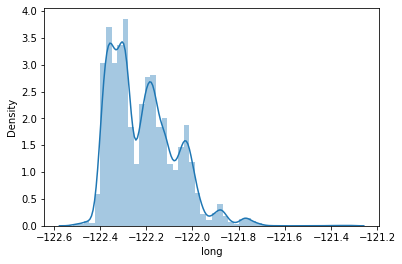

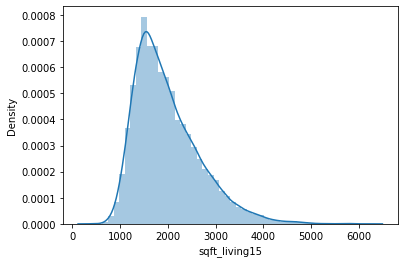

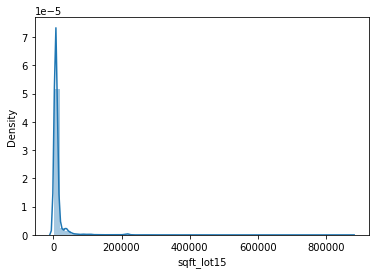

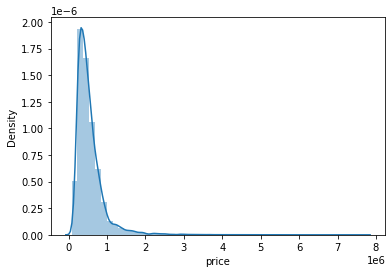

In [ ]:
for i in num:
    sns.distplot(num[i])
    plt.show()

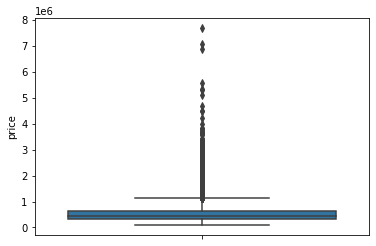

In [ ]:
sns.boxplot(y = 'price', data=num)
plt.show()

### Check for interesting relations between numerical variables with scatter plots

####(notice that during the various binning processes we name the labels to be from 0 to 1 so that we avoid doing the encoding altogether later)

plotting long vs lat produce a topview of the seattle area
- decided to bin zipcodes into 8 **equally distributed** bins upon correlation with tableau data we saw that central area are more costly than outer ones

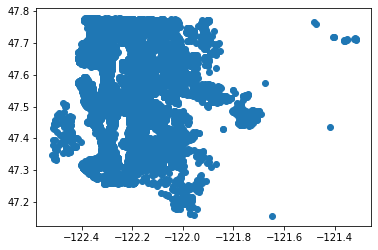

In [ ]:
plt.scatter(data['long'],data['lat'])
plt.show()

In [ ]:
data['avg_houseprice_region']= data.groupby(['zipcode'])['price'].transform('mean')

bin_labels_8 = ['0.125','0.25','0.375', '0.5','0.625','0.75','0.875','1']
data['zipcodenew'] = pd.qcut(data['avg_houseprice_region'],
                              q=[0, .125, .25, .375, .5, .625, .75, .875, 1],
                              labels=bin_labels_8)

data['zipcodenew']=data['zipcodenew'].astype(float)

here we inspected on the effect of grade on price, thought of merging first 4-5 grades but it worsen the accuracy bc indeed they influence significantly

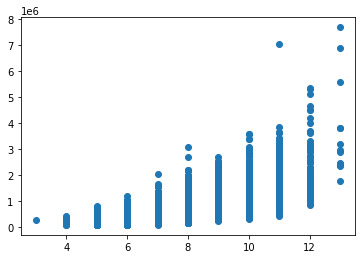

In [ ]:
plt.scatter(data['grade'], data['price'])
plt.show()

In [ ]:
#wanted to get rid of grade 1 to 6 and putting in 1 bin because they do not influence price --> it does influence so the model goes down --> dont do it

# ranges = [0, 6, 7, 8, 9, 10, 11, 12, np.inf]  # np.inf for infinity
# labels = ['0.125','0.25','0.375', '0.5','0.625','0.75','0.875','1']
# data['gradenew'] = pd.cut(data['grade'], 
#                                   bins=ranges, 
#                                   labels=labels)


investigating on price over time, it goes down before WW2 with big drop ar 1945 (...) and then goes up again. We also saw that it correlates to sqft living --> after the war houses costed more bc they were bigger and bigger

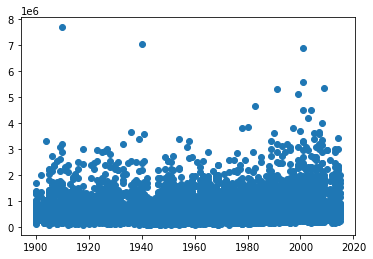

In [ ]:
plt.scatter(data['yr_built'], data['price'])
plt.show()

#WW2 ended in 1945 and we can see a drop in price for houses built in that year, probably because material sucks

In [ ]:
#putting together yr built with yr renovated // substituting empty ones in renov with built and replacing the built if it was renovated
data['year']=data['yr_built'].where(data['yr_renovated']==0)
data['year']=data['year'].fillna(data['yr_renovated'])
data=data.drop(['yr_built','yr_renovated'], axis=1)

In [ ]:
#we bin the yr_built according to the avg_price
data['avg_price_yr']= data.groupby(['year'])['price'].transform('mean')

ranges = [300000, 400000, 500000, 600000, 700000, 800000, np.inf] 
labels = ['0', '0.2', '0.4', '0.6','0.8','1']
data['year_new'] = pd.cut(data['avg_price_yr'], 
                                  bins=ranges, 
                                  labels=labels)

data['year_new']=data['year_new'].astype(float)

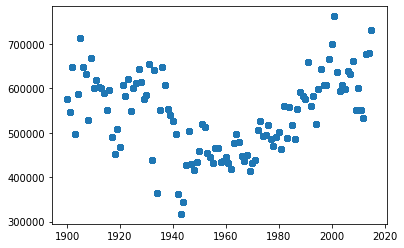

In [ ]:
plt.scatter(data['year'], data['avg_price_yr'] )
plt.show()

basement dimension influences the price but it not addressed on the sqft living (contrary to above space). We initially thought of making it binomial (basement yes or no) but decided to bin it to keep information of size and how it affects price.

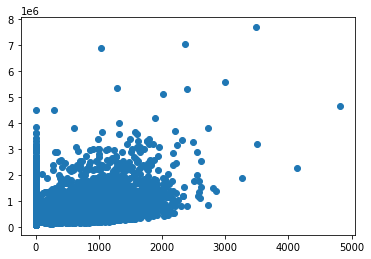

In [ ]:
plt.scatter(data['sqft_basement'],data['price'])
plt.show()

In [ ]:
#binning the basement to avoid losing info about the size
ranges = [-1, 0, 1000, 2500, np.inf]  # np.inf for infinity
labels = ['0', '0.33', '0.66', '1']
data['sqft_basement_new'] = pd.cut(data['sqft_basement'], 
                                  bins=ranges, 
                                  labels=labels)
data['sqft_basement_new']=data['sqft_basement_new'].astype(float)

binning zipcode according to price distribution (higher in the centre and less costly in periphery) improves the model greatly. But even more so does the ##**geohashing**. We divide the territory in smaller tiles according to long and lat (zipcode covers too big area) and take the avg of houses in that tile for prediction in the same tile. Improves the model a lot but is defective of not very densely populater areas for obvious reasons.


In [ ]:
data['geohash']=data.apply(lambda x: gh.encode(x.lat, x.long, precision=7), axis=1)
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,price,avg_houseprice_region,zipcodenew,year,avg_price_yr,year_new,sqft_basement_new,geohash
0,7129300520,10/13/14,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,98178,47.5112,-122.257,1340,5650,221900,310612.755725,0.250,1955.0,431361.256809,0.2,0.00,c23n3cp
1,6414100192,12/9/14,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,98125,47.7210,-122.319,1690,7639,538000,469928.767726,0.500,1991.0,659391.625514,0.6,0.33,c23p2x6
2,5631500400,2/25/15,2,1.00,770,10000,1.0,0,0,3,6,770,0,98028,47.7379,-122.233,2720,8062,180000,462488.869258,0.500,1933.0,641913.043478,0.6,0.00,c23pdd2
3,2487200875,12/9/14,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,98136,47.5208,-122.393,1360,5000,604000,551768.520913,0.625,1965.0,479105.834254,0.2,0.33,c22yqfu
4,1954400510,2/18/15,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,98074,47.6168,-122.045,1800,7503,510000,685675.843537,0.875,1987.0,553773.828479,0.4,0.00,c23nyu3


In [ ]:
data['avg_houseprice_geohash']= data.groupby(['geohash'])['price'].transform('mean')

In [ ]:
longlat_labels = ['0_gh','1_gh', '2_gh', '3_gh', '4_gh', '5_gh','6_gh', '7_gh', '8_gh']
data['geohash_new'] = pd.qcut(data['avg_houseprice_geohash'], 9, labels=longlat_labels)
data_cats=data[['geohash_new']]
data_cats.geohash_new.value_counts()

0_gh    2439
7_gh    2416
3_gh    2405
5_gh    2402
2_gh    2402
4_gh    2398
6_gh    2392
8_gh    2382
1_gh    2361
Name: geohash_new, dtype: int64

In [ ]:
data.head(5)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,price,avg_houseprice_region,zipcodenew,year,avg_price_yr,year_new,sqft_basement_new,geohash,avg_houseprice_geohash,geohash_new
0,7129300520,10/13/14,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,98178,47.5112,-122.257,1340,5650,221900,310612.755725,0.250,1955.0,431361.256809,0.2,0.00,c23n3cp,297980.000000,1_gh
1,6414100192,12/9/14,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,98125,47.7210,-122.319,1690,7639,538000,469928.767726,0.500,1991.0,659391.625514,0.6,0.33,c23p2x6,489000.000000,4_gh
2,5631500400,2/25/15,2,1.00,770,10000,1.0,0,0,3,6,770,0,98028,47.7379,-122.233,2720,8062,180000,462488.869258,0.500,1933.0,641913.043478,0.6,0.00,c23pdd2,180000.000000,0_gh
3,2487200875,12/9/14,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,98136,47.5208,-122.393,1360,5000,604000,551768.520913,0.625,1965.0,479105.834254,0.2,0.33,c22yqfu,769333.333333,7_gh
4,1954400510,2/18/15,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,98074,47.6168,-122.045,1800,7503,510000,685675.843537,0.875,1987.0,553773.828479,0.4,0.00,c23nyu3,546500.000000,5_gh


In [ ]:
data['date']= pd.to_datetime(data['date'],errors='coerce')
# data['zipcode']= data['zipcode'].astype(str)

###using pairplot to visualize if all the sqft have linear relation with one another




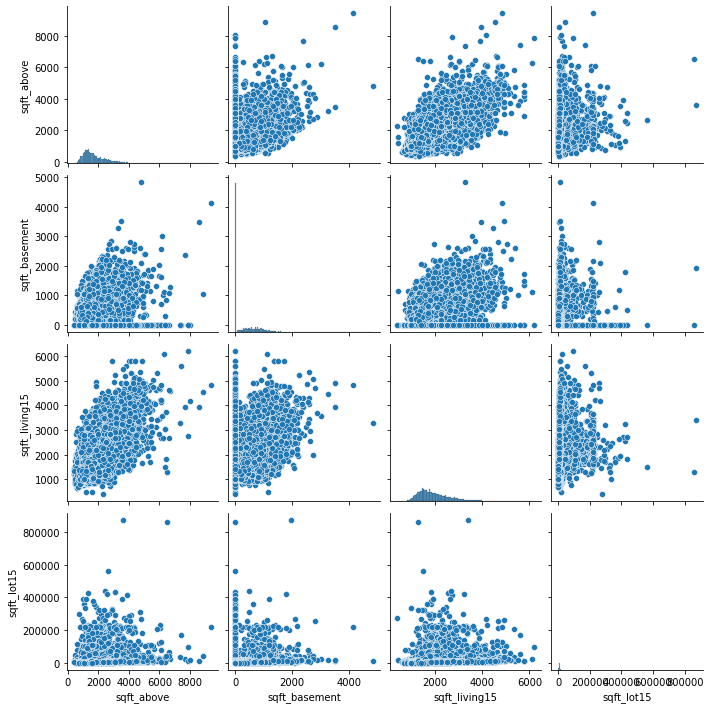

In [ ]:
sns.pairplot(data[['sqft_above','sqft_basement','sqft_living15','sqft_lot15']])

##dropping columns for various reasons happen here

In [ ]:
data= data.drop(['year','zipcode','condition','long','sqft_living', 'sqft_lot','date','sqft_above','id','avg_houseprice_region','avg_price_yr', 'geohash','avg_houseprice_geohash','sqft_basement', 'sqft_lot15'], axis = 1)

##outliers removal based on filtering manually instead of iqr
after visualizing it on tableau

In [ ]:
#removing outliers based on the plots //more than 6 bedrooms, more than 6 bathrooms and more than 6millions houses are considered out of the normal distribution
data.drop(index=data[(data['bedrooms'] > 6)].index)
data.drop(index=data[(data['bathrooms'] > 6)].index)
data.drop(index=data[(data['price'] > 6000000)].index)

In [ ]:
# iqr = np.percentile(data['price'],75) - np.percentile(data['price'],25)
# upper_limit = np.percentile(data['price'],75) + iqr
# lower_limit = np.percentile(data['price'],25) - iqr
# data=data[(data['price']>lower_limit) & (data['price']<upper_limit)]

##Transforming the Y target to make it more of a normal distribution
doing this influence the output of prediction 
when employing the model for actual prediction the result needs to be transformed back with the opposite mathematical operation (log -exp)

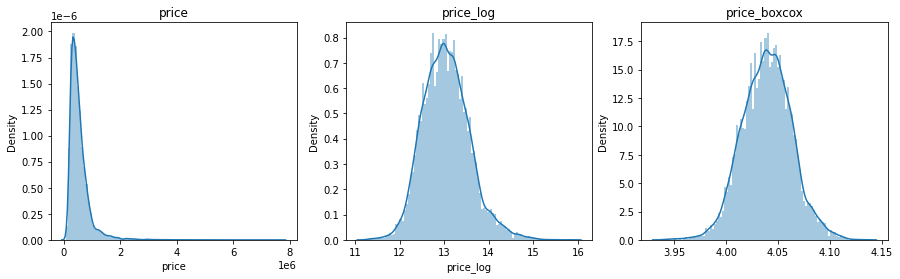

In [ ]:
from scipy import stats
def feat_log_box(df, feature, bins):
    """makes a log Transformation and a boxcox transformation of a feature of a dataframe. \n
    0 values are replaced with the mean in the transformation: \n
    plots 3 distplots next to each other for comparison \n
    tales 3 arguments (df, feature, bins)"""
    df[feature+'_log'] = list(map(lambda x: np.log(x) if np.isfinite(x) else np.NAN, df[feature]))
    df[feature+'_log'] = df[feature+'_log'].fillna(np.mean(df[feature+'_log']))
    df[feature+'_boxcox'] = np.where(df[feature]<=0,0,df[feature])
    mean = np.sum(df[feature+'_boxcox'])/len(df[df[feature+'_boxcox']>0])
    df[feature+'_boxcox'] = df[feature+'_boxcox'].replace(0,mean)
    xt, lmbda = stats.boxcox(df[feature+'_boxcox'])
    df[feature+'_boxcox'] = xt
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,4))
    sns.distplot(df[feature], bins, ax=ax1)
    ax1.set_title(feature)
    sns.distplot(df[feature+'_log'], bins, ax=ax2)
    ax2.set_title(feature + '_log')
    sns.distplot(xt, bins, ax=ax3)
    ax3.set_title(feature + '_boxcox')
    
feat_log_box(data, 'price', 100)

In [ ]:
num=data.select_dtypes(include='number')

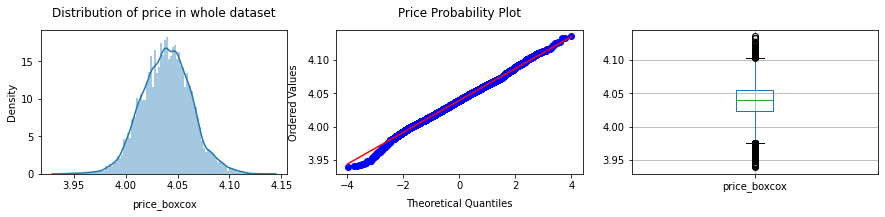

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,2))
plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None)

sns.distplot(num['price_boxcox'], hist=True, bins = 100, ax=ax1)
probplot(num['price_boxcox'], plot=ax2)
data.boxplot('price_boxcox', ax=ax3)

ax1.set_xlabel('price_boxcox', size=10, labelpad=8)
ax2.set_xlabel('Theoretical Quantiles', size=10, labelpad=8)
ax2.set_ylabel('Ordered Values', size=10, labelpad=8)

ax1.set_title('Distribution of price in whole dataset', size=12, y=1.05)
ax2.set_title('Price Probability Plot', size=12, y=1.05)

plt.show()

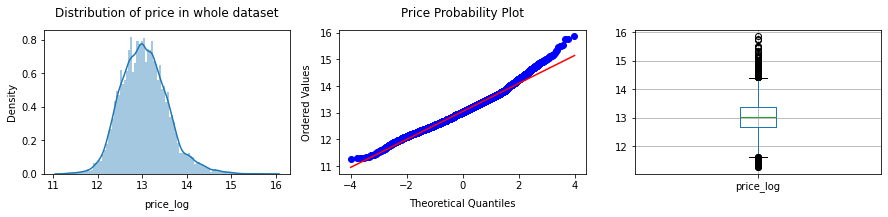

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,2))
plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None)

sns.distplot(num['price_log'], hist=True, bins = 100, ax=ax1)
probplot(num['price_log'], plot=ax2)
data.boxplot('price_log', ax=ax3)

ax1.set_xlabel('price_log', size=10, labelpad=8)
ax2.set_xlabel('Theoretical Quantiles', size=10, labelpad=8)
ax2.set_ylabel('Ordered Values', size=10, labelpad=8)

ax1.set_title('Distribution of price in whole dataset', size=12, y=1.05)
ax2.set_title('Price Probability Plot', size=12, y=1.05)

plt.show()

Separate your Y from num

In [ ]:
Y = num['price_log']
num = num.drop(['price_boxcox', 'price_log'], axis=1)

Having done with data manipulation we check again the correlation map, see decent correlation between Xs and Y and low correlation between Xs

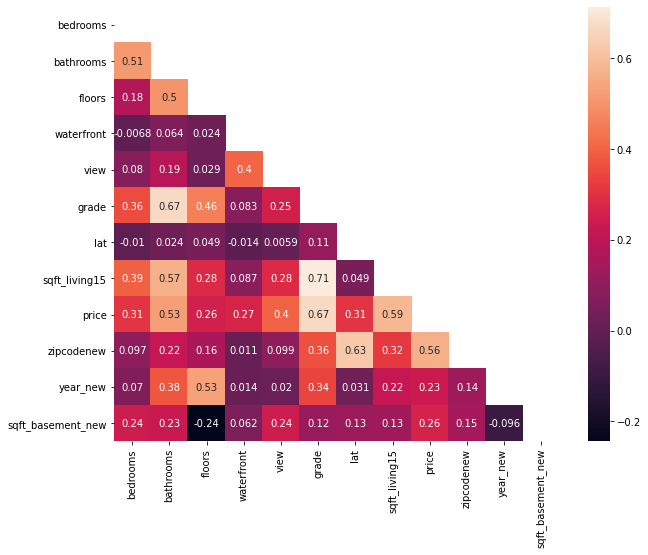

In [ ]:
correlations_matrix= num.corr()
mask = np.zeros_like(correlations_matrix)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)
plt.show()

In [ ]:
num = num.drop(['price'], axis=1)

In [ ]:
cat=data.select_dtypes(include='category')

next, basically encoding only for the geohash

In [ ]:
encoded=pd.get_dummies(cat, drop_first=True)
print(encoded)
type(encoded)
encoded.shape

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(21597, 8)

In [ ]:
from sklearn.preprocessing import StandardScaler #normalizer is an alternative to Standardscaler. Norm distributes between 0 and 1, Sscaler distributes between -1 an +1
fitted = StandardScaler().fit(num)
x_scaled = fitted.transform(num)
print(x_scaled.shape)
x=pd.DataFrame(x_scaled)

(21597, 11)


In [ ]:
X = np.concatenate((x, encoded), axis=1)
pd.DataFrame(X).head()
X.shape

(21597, 19)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=100)

In [ ]:
from sklearn import linear_model

In [ ]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train,y_train)
predictions  = lm.predict(X_test)
r2=r2_score(y_test, predictions)
r2

0.9140860604057093

Validation

In [ ]:
import sklearn.metrics as metrics

def regression_results(dic_of_models, y_true):
    '''returns a dataframe with 'Model', 'expl_variance', 'r2', 'MAE', 'MSE', 'RMSE', 'MSLE',
    need the dictionary of key='modelname', value=prediction, X_test, y_test as attributes'''
    model_val = pd.DataFrame(columns =['Model', 'expl_variance', 'r2', 'MAE', 'MSE', 'RMSE', 'MSLE'])
    # Regression metrics
    for key, y_pred in dic_of_models.items():
        explained_variance=metrics.explained_variance_score(y_true, y_pred)
        mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
        mse=metrics.mean_squared_error(y_true, y_pred) 
        mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
        median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
        r2=metrics.r2_score(y_true, y_pred)
        val_list = [key, 
                explained_variance,
                round(r2,4),
                round(mean_absolute_error,4),
                round(mse,4),
                round(np.sqrt(mse),4),
                round(mean_squared_log_error,4)]
        v_series = pd.Series(val_list, index = model_val.columns)
        model_val = model_val.append(v_series, ignore_index=True)
    return model_val

In [ ]:
model_dic = {'model1': predictions,}


In [ ]:
regression_results(model_dic, y_test)

,Model,expl_variance,r2,MAE,MSE,RMSE,MSLE
0,model1,0.914087,0.9141,0.1071,0.0239,0.1546,0.0001


In [ ]:
n = len(x)
p = x.shape[1]
adj_r2 = 1-((1-r2)*(n-1)/(n-p-1))
adj_r2

0.9140422775316979

In [ ]:
def plot_errors(y, y_pred):
    
    
 #   fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,4))
  #  plt.subplots_adjust(left=None, bottom=5, right=None, top=6, wspace=None, hspace=None)
    fig, ax = plt.subplots()
    sns.set(color_codes=True)
    sns.set(rc={'figure.figsize':(7, 7)})
    plt.ylabel("Predicted 'price'")
    plt.title("Test set: Predictions against real values")
    X_plot = np.linspace(10, 16, 16)
    Y_plot = X_plot
    sns.regplot(x=y, y=y_pred, fit_reg=False, ax=ax,scatter_kws={"color": "blue", "s":1})
    plt.plot(X_plot, Y_plot, color='r',linewidth=4.)
    plt.show()
    
    sns.displot(y-y_pred, kde=True, ax=ax2)
    plt.title("Train set: Distribution of residuals")
    plt.show()

In [ ]:
plot_errors(y_test, model1 )

###Creating & Storing the model

In [ ]:
import pickle
# save the model to disk
filename = 'house_regression_geohash.sav'
pickle.dump(rf4_xsmall_l, open(filename, 'wb'))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

In [ ]:
data_csv = data1[['sqft_living', 'waterfront', 'view', 'bedrooms_bathr', 'geohash_new']]
data_csv['price'] = data['price']
data_csv.head()

In [ ]:
data_csv.to_csv('X_y_Regr_geoh_no_dupl.csv', index = False)

In [ ]:
import statsmodels.api as sm

ols=sm.add_constant(X4_xsmall_l_train)
mod = sm.OLS(y4_xsmall_l_train, ols)
res = mod.fit()

print(res.summary())

In [ ]:
import matplotlib.pyplot as plt
importance = rf4_xsmall_l.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
sns.barplot([x for x in range(len(importance))], importance)